In [1]:
import pandas as pd
import os
import json
import sys
import matplotlib.pyplot as plt
import originpro as op
import numpy as np
from scipy.interpolate import interp1d

In [2]:
path = r"C:\Users\flahertylab\OneDrive - Georgia Institute of Technology\Flaherty Research Group - ESS\01 - Raman Data\ESS-1-165_O2_cutoff_redux\20ppmCl\04kPa O2\Spectra BS09"
base_path = os.path.dirname(path)
file_name = "ESS-1-165_04kPaO2_20ppmCl_corrected_BS09"

save_path = os.path.join(base_path, f"{file_name}.opju")

dirlist = os.listdir(path)


df_list = []
for file in dirlist:
    file_path = path + "\\" + file
    name, extension = os.path.splitext(file)
    try:
        time = int(name.split('_')[-1])
    except ValueError:
        pass
    df_temp = pd.read_csv(file_path, sep='\t', names=['Wavenumber',time])
    df_list.append(df_temp)

# Merge data
df = df_list[0][['Wavenumber']]  # just one copy of Wavenumber
data_cols = [df_temp.iloc[:, 1] for df_temp in df_list]
df = pd.concat([df] + data_cols, axis=1)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.set_index('Wavenumber')

# Sort data
cols = df.columns.tolist()
cols_sorted = sorted(cols, key=lambda x: float(x))
df = df[cols_sorted]
df = df[::-1]
df

,0,37,75,113,151,189,227,265,303,341,...,122496,122534,122572,122610,122648,122685,122723,122761,122799,122824
Wavenumber,,,,,,,,,,,,,,,,,,,,,
99.308594,-5.936687,-4.812848,-8.683439,-4.039954,-1.418991,10.846983,-20.842169,-10.833186,2.582420,-0.737819,...,7.373004,-4.675702,-3.212792,2.089280,-1.426392,-0.735776,-4.217825,-2.554695,-5.136524,-1.336442
101.273438,734.281128,1279.090576,1213.253662,736.673889,982.690735,1159.728638,1215.175171,868.615173,1221.789795,1143.260376,...,856.878418,1183.771973,1177.295898,1118.076904,995.356201,1096.686279,1163.913086,1391.126343,1166.934937,628.677734
103.236328,2886.917480,2692.730957,2629.266357,2808.043701,3264.242188,2519.880371,2605.278076,2229.617676,2992.143555,3034.155273,...,2093.892578,2475.960938,2585.526367,3113.423096,2275.559570,3120.977295,3083.525879,2906.111328,2982.197754,2097.669434
105.199219,4944.935547,5318.038086,5521.264160,5508.405273,5508.184082,4991.209961,5206.414063,5011.305176,4941.446289,5274.335449,...,4765.711426,4979.620117,5020.914063,4317.314941,4880.515137,5246.459473,5561.281738,4956.233887,5118.154785,3397.552734
107.162109,8538.130859,8140.191895,8603.097656,8543.390625,9194.615234,8101.549805,8276.224609,7906.383789,8523.892578,8678.305664,...,7675.669922,8276.970703,8193.174805,7665.866699,8074.286133,8179.544434,8088.063477,7864.998047,8258.038086,5784.511230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864.859375,492.897339,144.391663,-271.373901,-592.703674,678.672974,823.133972,908.491516,-279.331085,211.863953,373.559784,...,206.405762,89.360641,474.444153,-65.247124,426.715302,-10.657579,643.258362,1024.520508,311.436279,88.552971
1866.421875,546.202820,-272.764679,-200.758179,272.417938,873.350342,1096.551025,749.177307,158.577637,-141.560837,423.343414,...,907.696655,364.998810,574.694763,348.456909,-51.463802,239.770096,421.365173,807.273682,20.058542,-109.072533
1867.982422,770.466614,150.604309,-205.782623,160.839828,853.841858,1009.106506,668.908936,576.606323,133.251587,545.151672,...,779.542419,688.590637,337.759369,-56.972984,390.046814,37.425762,795.803040,1208.785400,164.203293,134.834915


In [3]:
def linearize_and_resample(
    df,
    poly_order=2,
    n_points=None,
    interp_kind='cubic',
    pct_threshold=0.03,
    make_diagnostic_plot=True,
):
    """
    Linearize (if needed) and resample a spectral DataFrame along its index.

    Parameters
    ----------
    df : pd.DataFrame
        index = wavenumber (numeric), columns = other axis, values = intensity
    poly_order : int
        polynomial degree to fit inverse mapping (position = g(coord))
    n_points : int or None
        number of samples in output linear grid; default = len(df.index)
    interp_kind : str
        interpolation kind for interp1d ('linear','cubic', etc.)
    pct_threshold : float
        fractional threshold (e.g. 0.03 for 3%). If max abs dev > this,
        polynomial correction is applied.
    make_diagnostic_plot : bool
        show diagnostic plots (index deviation and sample overlay)

    Returns
    -------
    df_out : pd.DataFrame
        DataFrame resampled to a linear wavenumber grid (index = linear coords)
    info : dict
        diagnostic info: { 'need_correction', 'max_pct_dev', 'poly_coeffs', ... }
    """

    # --- prepare axes and orientation sanity ---
    coords = np.asarray(df.index, dtype=float)
    if np.any(np.isnan(coords)):
        raise ValueError("Index contains NaN; please clean index first.")
    # Ensure monotonic increasing index
    reversed_index = False
    if not np.all(np.diff(coords) > 0):
        # if decreasing, flip to increasing
        if np.all(np.diff(coords[::-1]) > 0):
            df = df.iloc[::-1].copy()
            coords = np.asarray(df.index, dtype=float)
            reversed_index = True
        else:
            raise ValueError("Index is not monotonic; cannot proceed.")

    positions = np.arange(len(coords), dtype=float)

    # diagnostic: deviation from perfect linear spacing (percent)
    linear_guess = np.linspace(coords[0], coords[-1], len(coords))
    pct_dev = (coords - linear_guess) / coords * 100.0
    max_pct_dev = np.nanmax(np.abs(pct_dev)) / 100.0  # fractional

    need_correction = max_pct_dev > pct_threshold

    # choose number of output points
    if n_points is None:
        n_points = len(coords)

    # Build target linear coordinate grid
    linear_coords = np.linspace(coords.min(), coords.max(), n_points)

    poly_coeffs = None
    df_out = None

    if need_correction:
        # Fit inverse mapping: position = g(coord)
        poly_coeffs = np.polyfit(coords, positions, poly_order)
        # Evaluate positions for each desired linear coordinate
        pos_for_linear = np.polyval(poly_coeffs, linear_coords)

        # Interpolate over row positions (safe monotonic domain)
        interp_pos = interp1d(positions, df.values, axis=0,
                              kind=interp_kind, bounds_error=False, fill_value=np.nan)

        linear_data = interp_pos(pos_for_linear)

        # Remove any rows that are NaN because they mapped outside original range
        valid_mask = ~np.isnan(linear_data).all(axis=1)
        linear_data = linear_data[valid_mask]
        linear_coords_valid = linear_coords[valid_mask]

        df_out = pd.DataFrame(linear_data, index=linear_coords_valid, columns=df.columns)
        df_out.index.name = df.index.name

    else:
        # No significant nonlinear deviation: simple interpolation over original coords
        interp_func = interp1d(coords, df.values, axis=0,
                               kind=interp_kind, bounds_error=False, fill_value=np.nan)
        linear_data = interp_func(linear_coords)
        valid_mask = ~np.isnan(linear_data).all(axis=1)
        df_out = pd.DataFrame(linear_data[valid_mask], index=linear_coords[valid_mask], columns=df.columns)
        df_out.index.name = df.index.name

    info = {
        'need_correction': need_correction,
        'max_pct_dev': max_pct_dev,
        'poly_order': poly_order if need_correction else None,
        'poly_coeffs': poly_coeffs,
        'n_output_points_requested': n_points,
        'n_output_points_actual': len(df_out.index),
    }

    if make_diagnostic_plot:
        # plot percent deviation diagnostic
        fig, axes = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True)
        axes[0].plot(linear_guess, pct_dev, label='(coords - linear_guess)/coords *100')
        axes[0].axhline(0, color='k', lw=0.6)
        axes[0].set_ylabel('Percent deviation (%)')
        axes[0].legend()
        axes[0].set_title(f"Max abs pct dev = {100*max_pct_dev:.2f}%  -> need_correction={need_correction}")

        # overlay one representative column (middle) raw vs resampled
        col_idx = df.columns[len(df.columns)//2]
        # plot raw (against original coords)
        axes[1].plot(coords, df[col_idx].values, label='raw', alpha=0.8)
        axes[1].plot(df_out.index.values, df_out[col_idx].values, '--', label='resampled', alpha=0.9)
        axes[1].set_xlabel(df.index.name or 'coord')
        axes[1].set_ylabel('Intensity')
        axes[1].legend()
        plt.show()

    return df_out, info

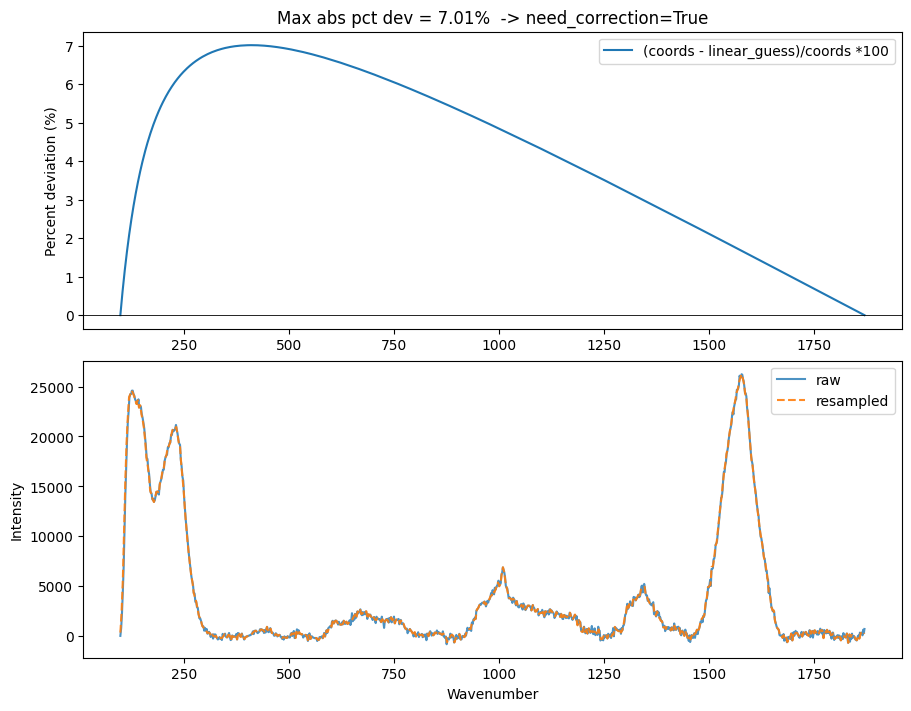

{'need_correction': np.True_, 'max_pct_dev': np.float64(0.07011869125822322), 'poly_order': 2, 'poly_coeffs': array([ 3.73025221e-05,  4.98211140e-01, -4.92929405e+01]), 'n_output_points_requested': 600, 'n_output_points_actual': 600}


In [4]:
df_linear, info = linearize_and_resample(df, poly_order=2, n_points=600, interp_kind='cubic',
                                         pct_threshold=0.05, make_diagnostic_plot=True)
print(info)


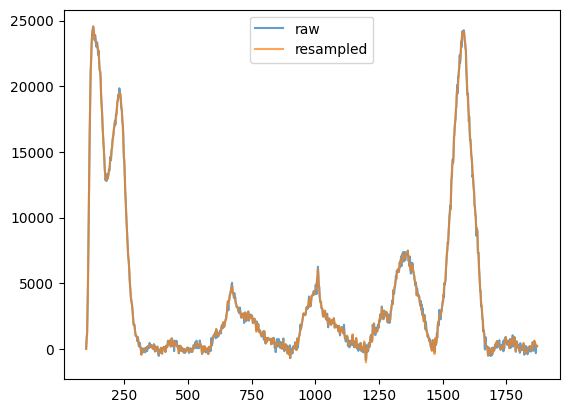

In [5]:
from scipy.interpolate import interp1d
import numpy as np

# original wavenumber axis and data
x = df.index.to_numpy()
y = df[2919].to_numpy()  # or loop over columns

# create a new *linearly spaced* wavenumber axis
new_x = np.linspace(x.min(), x.max(), len(x)//2)  # reduce to half resolution (for example)

# interpolate intensity to new axis
f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
new_y = f(new_x)

# visualize
plt.plot(x, y, label='raw', alpha=0.7)
plt.plot(new_x, new_y, label='resampled', alpha=0.7)
plt.legend()
plt.show()


In [6]:
# Average data
row_bin_size = 4  # ~1015 / 4 ≈ 254
col_bin_size = 3  # ~230 / 3 ≈ 76

# Average columns (time)
col_bins = np.floor(np.arange(len(df_linear.columns)) / col_bin_size)
df_avg_cols = df_linear.groupby(col_bins, axis=1).mean()
df_avg_cols.columns = df_linear.columns.to_series().groupby(col_bins).mean()

# Average rows (wavenumber)
row_bins = np.floor(np.arange(len(df_avg_cols.index)) / row_bin_size)
df_smoothed = df_avg_cols.groupby(row_bins, axis=0).mean()
df_smoothed.index = df_avg_cols.index.to_series().groupby(row_bins).mean()
df_smoothed

C:\Users\flahertylab\AppData\Local\Temp\ipykernel_34016\2102927124.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_avg_cols = df_linear.groupby(col_bins, axis=1).mean()
C:\Users\flahertylab\AppData\Local\Temp\ipykernel_34016\2102927124.py:12: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_smoothed = df_avg_cols.groupby(row_bins, axis=0).mean()


,37.333333,151.000000,265.000000,379.000000,492.000000,606.000000,720.000000,833.666667,947.000000,1061.000000,...,121851.000000,121965.000000,122079.000000,122192.666667,122306.000000,122420.000000,122534.000000,122647.666667,122761.000000,122824.000000
Wavenumber,,,,,,,,,,,,,,,,,,,,,
103.745476,5727.691813,5803.130901,5530.026967,5219.964929,5105.063341,5105.287184,5258.209963,5180.438721,5424.116209,5286.662489,...,5485.109859,5363.919112,5823.844976,5380.648942,5758.628797,5098.990149,5291.654045,5356.907285,5551.583488,3773.724818
115.577162,24039.746475,24586.591519,23772.287410,22954.599103,23143.626868,22659.177846,22310.246822,22891.986015,22728.114280,22193.894994,...,22738.847937,22814.606317,23734.385619,22823.277621,23204.889172,21974.394614,22010.462765,22298.800747,22657.357815,15740.239145
127.408847,29741.748418,30396.971724,29057.059460,28399.738229,28752.129002,27921.521807,27562.327461,28145.817997,27899.050241,27298.728729,...,28542.298649,28571.925618,29733.226623,28572.092472,28866.189139,27246.152111,27351.823092,27767.317106,28321.654917,19782.549966
139.240533,29120.908517,29799.702666,28313.528598,27726.880456,28136.243638,27052.329329,26684.316595,27456.874916,27041.842124,26741.690057,...,28272.503996,28321.823751,29613.505726,28412.662451,28727.741713,26607.360328,26959.983322,27388.562457,28100.752534,19845.751295
151.072219,27379.309173,27945.516981,26293.051827,25772.675624,26446.619736,25128.070491,24804.304705,25554.941231,25225.182993,24831.019664,...,26627.008924,26802.619475,28421.892485,26847.511208,27024.451427,24901.276357,25464.748559,26080.308506,26600.424554,18962.532227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819.339891,1170.852496,469.218890,-19.027872,92.092704,230.155799,399.120398,84.242190,162.802992,279.017556,128.423316,...,597.653180,479.080437,980.275597,144.298719,502.653727,875.595693,275.218247,792.616406,375.090969,991.369229
1831.171577,566.185779,183.041305,-138.733154,-80.196430,13.282219,113.364724,-26.857973,47.279327,-0.482783,-13.112423,...,190.670738,66.332563,559.325257,-202.162428,290.570664,439.775003,-118.606668,267.067407,75.273759,440.470278
1843.003263,173.649778,-24.990437,-120.865680,-85.280933,3.536173,56.646274,-55.540550,-31.548563,-136.656115,-126.133473,...,-57.019430,-47.359256,144.169908,-167.389032,22.259144,134.848238,-139.612458,55.832904,-155.149255,254.516875


In [7]:
ref_wavenumber = 123.613770

df_norm = df_smoothed.div(df_smoothed.iloc[3])
df_norm

,37.333333,151.000000,265.000000,379.000000,492.000000,606.000000,720.000000,833.666667,947.000000,1061.000000,...,121851.000000,121965.000000,122079.000000,122192.666667,122306.000000,122420.000000,122534.000000,122647.666667,122761.000000,122824.000000
Wavenumber,,,,,,,,,,,,,,,,,,,,,
103.745476,0.196687,0.194738,0.195314,0.188264,0.181441,0.188719,0.197052,0.188675,0.200582,0.197694,...,0.194009,0.189392,0.196662,0.189375,0.200455,0.191638,0.196278,0.195589,0.197560,0.190153
115.577162,0.825515,0.825062,0.839609,0.827882,0.822556,0.837605,0.836081,0.833743,0.840480,0.829936,...,0.804274,0.805549,0.801472,0.803278,0.807752,0.825877,0.816412,0.814165,0.806290,0.793129
127.408847,1.021319,1.020043,1.026261,1.024267,1.021889,1.032130,1.032904,1.025092,1.031699,1.020830,...,1.009543,1.008831,1.004043,1.005611,1.004819,1.024008,1.014534,1.013829,1.007861,0.996815
139.240533,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
151.072219,0.940194,0.937778,0.928639,0.929519,0.939948,0.928869,0.929546,0.930730,0.932820,0.928551,...,0.941799,0.946359,0.959761,0.944914,0.940709,0.935879,0.944539,0.952234,0.946609,0.955496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819.339891,0.040207,0.015746,-0.000672,0.003321,0.008180,0.014754,0.003157,0.005929,0.010318,0.004802,...,0.021139,0.016916,0.033102,0.005079,0.017497,0.032908,0.010208,0.028940,0.013348,0.049954
1831.171577,0.019443,0.006142,-0.004900,-0.002892,0.000472,0.004191,-0.001007,0.001722,-0.000018,-0.000490,...,0.006744,0.002342,0.018888,-0.007115,0.010115,0.016528,-0.004399,0.009751,0.002679,0.022195
1843.003263,0.005963,-0.000839,-0.004269,-0.003076,0.000126,0.002094,-0.002081,-0.001149,-0.005054,-0.004717,...,-0.002017,-0.001672,0.004868,-0.005891,0.000775,0.005068,-0.005179,0.002039,-0.005521,0.012825


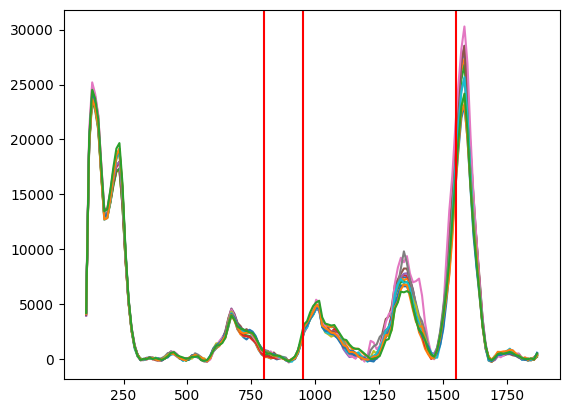

In [8]:
df_test = df_smoothed # , _smoothed,_norm
columns = df_test.columns[(df_test.columns > 2000) & (df_test.columns < 3500)]
#df_test[columns]
for spectrum in columns:
    plt.plot(df_test[spectrum])

plt.axvline(x=800, color='r')
plt.axvline(x=1550, color='r')
plt.axvline(x=950, color='r') 
test = df_test[columns]


In [9]:
# Convert df to long format for origin
df_norm.index.name = 'Wavenumber'
df_long = df_norm.reset_index().melt(id_vars='Wavenumber', var_name='Time', value_name='Intensity')
df_long

,Wavenumber,Time,Intensity
0,103.745476,37.333333,0.196687
1,115.577162,37.333333,0.825515
2,127.408847,37.333333,1.021319
3,139.240533,37.333333,1.000000
4,151.072219,37.333333,0.940194
...,...,...,...
162145,1819.339891,122824.0,0.049954
162146,1831.171577,122824.0,0.022195
162147,1843.003263,122824.0,0.012825
162148,1854.834948,122824.0,-0.001599


In [10]:
def origin_shutdown_exception_hook(extype, value, traceback):
    '''Ensures Origin gets shut down if there is an uncaught exception'''
    op.exit()
    sys.__excepthook__(extype, value, traceback)
if op and op.oext:
    sys.excepthook = origin_shutdown_exception_hook

if op.oext:
    op.set_show(True)

op.set_show(False)



np_mat = df.to_numpy()  #.astype(np.int64)
matbook = op.new_book('m','raw')
mat = matbook[0]
mat.from_np(np_mat)


xmin = df.columns[0] / 3600
xmax = df.columns[-1] / 3600
msheet = op.find_sheet('m', 'raw')
xymap = xmin, xmax, df.index[0], df.index[-1]
msheet.xymap = xymap
graph = op.new_graph(template='contour')
gl = graph[0]
plot = gl.add_mplot(msheet, z=0, type='contour')
gl.rescale()




np_mat = df_smoothed.to_numpy()  #.astype(np.int64)
matbook = op.new_book('m','smooth')
mat = matbook[0]
mat.from_np(np_mat)


xmin = df_smoothed.columns[0] / 3600
xmax = df_smoothed.columns[-1] / 3600
msheet = op.find_sheet('m', 'smooth')
msheet.xymap = xymap
graph = op.new_graph(template='contour')
gl = graph[0]
plot = gl.add_mplot(msheet, z=0, type='contour')
gl.rescale()






np_mat = df_norm.to_numpy()  #.astype(np.int64)
matbook = op.new_book('m',lname='norm')
mat = matbook[0]
mat.from_np(np_mat)

xmin = df_norm.columns[0] / 3600
xmax = df_norm.columns[-1] / 3600
msheet = op.find_sheet('m', 'norm')
msheet.xymap = xymap
graph = op.new_graph(template='contour') # TODO add str kwarg to name the graphs
gl = graph[0]
plot = gl.add_mplot(msheet, z=0, type='contour')
gl.rescale()





op.save(save_path)

# Code here
op.oext = True
if op.oext:
    op.exit()

In [11]:


#op.oext = True
#if op.oext:
#    op.exit()